In [ ]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Loading Data

In [ ]:
urls = {
    'CollisionRecords': 'https://firebasestorage.googleapis.com/v0/b/aiq-bot.appspot.com/o/20210604_CollisionRecords.txt?alt=media&token=782c69aa-081b-421d-8399-a3e028bd643b',
    'PartyRecords': 'https://firebasestorage.googleapis.com/v0/b/aiq-bot.appspot.com/o/20210604_PartyRecords.txt?alt=media&token=b26667a0-3fdf-4c19-ae9f-2c3e3799bc92',
    'VictimRecords': 'https://firebasestorage.googleapis.com/v0/b/aiq-bot.appspot.com/o/20210604_VictimRecords.txt?alt=media&token=e56a2905-34b2-49a9-9d48-6ed5b9f4f753'
}

In [ ]:
dtype1={'BICYCLE_ACCIDENT': 'object',
       'MOTORCYCLE_ACCIDENT': 'object',
       'PEDESTRIAN_ACCIDENT': 'object',
       'TRUCK_ACCIDENT': 'object',
       'COLLISION_SEVERITY': 'object'
}

dtype2={'PARTY_TYPE': 'float64'}

usecols1 = [
    'CASE_ID', 'COLLISION_DATE', 'COLLISION_TIME', 'DAY_OF_WEEK', 'COLLISION_SEVERITY',
    'WEATHER_1', 'ROAD_SURFACE', 'LIGHTING', 'CONTROL_DEVICE',
    'TYPE_OF_COLLISION', 'MOTORCYCLE_ACCIDENT', 'BICYCLE_ACCIDENT', 'PEDESTRIAN_ACCIDENT',
    'TRUCK_ACCIDENT'
]

usecols2 = [
    'PARTY_TYPE', 'PARTY_AGE', 'PARTY_SEX', 'AT_FAULT',
    'PARTY_SOBRIETY'
]

usecols3 = [
    'VICTIM_SEX', 'VICTIM_AGE', 'VICTIM_DEGREE_OF_INJURY'
]

# Read the datasets
collision_raw = dd.read_csv(urls['CollisionRecords'], usecols=usecols1, na_values=["-", "- "], dtype=dtype1)
party_raw = dd.read_csv(urls['PartyRecords'], usecols=usecols2, na_values=["-", "- "], dtype=dtype2)
victim_raw = dd.read_csv(urls['VictimRecords'], usecols=usecols3, na_values=["-", "- "])

In [ ]:
# Convert Dask DataFrame to Pandas for EDA
collision_df = collision_raw.compute()
party_df = party_raw.compute()
victim_df = victim_raw.compute()


# Exploratory Data Analysis

In [ ]:
# Function to perform value counts on all columns
def value_counts_for_all_columns(df):
    for column in df.columns:
        print(f"Value counts for {column}:")
        print(df[column].value_counts(dropna=False))
        print("\n")

In [ ]:
# Data Cleanup
collision_df['WEATHER_1'] = collision_df['WEATHER_1'].replace('N', "UNKNOWN")
collision_df['WEATHER_1'] = collision_df['WEATHER_1'].fillna('UNKNOWN')
collision_df['COLLISION_SEVERITY'] = collision_df['COLLISION_SEVERITY'].replace('N', "UNKNOWN")
collision_df['COLLISION_SEVERITY'] = collision_df['COLLISION_SEVERITY'].fillna('UNKNOWN')
collision_df['TYPE_OF_COLLISION'] = collision_df['TYPE_OF_COLLISION'].replace(['I', 'N', 'M', 'O', ' '], "UNKNOWN")
collision_df['TYPE_OF_COLLISION'] = collision_df['TYPE_OF_COLLISION'].fillna('UNKNOWN')
collision_df['ROAD_SURFACE'] = collision_df['ROAD_SURFACE'].replace(['H','I', 'J',' '], "UNKNOWN")
collision_df['ROAD_SURFACE'] = collision_df['ROAD_SURFACE'].fillna('UNKNOWN')
collision_df['LIGHTING'] = collision_df['LIGHTING'].replace(['G', ' '], "UNKNOWN")
collision_df['LIGHTING'] = collision_df['LIGHTING'].fillna('UNKNOWN')
collision_df['CONTROL_DEVICE'] = collision_df['CONTROL_DEVICE'].replace(['H', 'E', ' ', 'Q', '0', 'G'], "UNKNOWN")
collision_df['CONTROL_DEVICE'] = collision_df['CONTROL_DEVICE'].fillna('UNKNOWN')
collision_df['PEDESTRIAN_ACCIDENT'] = collision_df['PEDESTRIAN_ACCIDENT'].replace(['0'], "UNKNOWN")
collision_df['PEDESTRIAN_ACCIDENT'] = collision_df['PEDESTRIAN_ACCIDENT'].fillna('N')
collision_df['MOTORCYCLE_ACCIDENT'] = collision_df['MOTORCYCLE_ACCIDENT'].fillna('N')
collision_df['BICYCLE_ACCIDENT'] = collision_df['BICYCLE_ACCIDENT'].fillna('N')
collision_df['TRUCK_ACCIDENT'] = collision_df['TRUCK_ACCIDENT'].fillna('N')

In [ ]:
party_df['PARTY_TYPE'] = party_df['PARTY_TYPE'].fillna("UNKNOWN").astype(str)
party_df['PARTY_TYPE'] = party_df['PARTY_TYPE'].str.replace('.0', '', regex=True).astype(str)
party_df['PARTY_SEX'] = party_df['PARTY_SEX'].replace(['X', ' '], "UNKNOWN")
party_df['PARTY_SEX'] = party_df['PARTY_SEX'].fillna('UNKNOWN')
party_df['PARTY_AGE'] = party_df['PARTY_AGE'].fillna('UNKNOWN')
party_df['PARTY_AGE'] = party_df['PARTY_AGE'].replace([0, 998], "UNKNOWN")
party_df['PARTY_SOBRIETY'] = party_df['PARTY_SOBRIETY'].fillna('UNKNOWN')

In [ ]:
victim_df['VICTIM_SEX'] = victim_df['VICTIM_SEX'].replace(['4', ' ', 'X', '3', '2', '1', 'N', 'U', 'G', 'W', 'B', 'H', '5'], "UNKNOWN")
victim_df['VICTIM_SEX'] = victim_df['VICTIM_SEX'].fillna('UNKNOWN')
victim_df['VICTIM_AGE'] = victim_df['VICTIM_AGE'].fillna('UNKNOWN')
victim_df['VICTIM_AGE'] = victim_df['VICTIM_AGE'].replace([0, 998], "UNKNOWN")
victim_df['VICTIM_DEGREE_OF_INJURY'] = victim_df['VICTIM_DEGREE_OF_INJURY'].fillna('UNKNOWN')
victim_df['VICTIM_DEGREE_OF_INJURY'] = victim_df['VICTIM_DEGREE_OF_INJURY'].replace([5, 6, 7], "UNKNOWN")

In [ ]:
print("Collision Dataset Shape:", collision_df.shape)
print("Collision Dataset Info:")
print(collision_df.info())

print("Collision Dataset Value Counts:")
value_counts_for_all_columns(collision_df)

Collision Dataset Shape: (5293361, 14)
Collision Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 5293361 entries, 0 to 202757
Data columns (total 14 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   CASE_ID              int64 
 1   COLLISION_DATE       int64 
 2   COLLISION_TIME       int64 
 3   DAY_OF_WEEK          int64 
 4   WEATHER_1            string
 5   COLLISION_SEVERITY   string
 6   TYPE_OF_COLLISION    string
 7   ROAD_SURFACE         string
 8   LIGHTING             string
 9   CONTROL_DEVICE       string
 10  PEDESTRIAN_ACCIDENT  string
 11  BICYCLE_ACCIDENT     string
 12  MOTORCYCLE_ACCIDENT  string
 13  TRUCK_ACCIDENT       string
dtypes: int64(4), string(10)
memory usage: 455.2 MB
None
Collision Dataset Value Counts:
Value counts for CASE_ID:
CASE_ID
81715      1
8790462    1
8790440    1
8790439    1
8790438    1
          ..
6086471    1
6086470    1
6086469    1
6086468    1
9292537    1
Name: count, Length: 5293361, dtype:

In [ ]:
print("Party Dataset Shape:", party_df.shape)
print("Party Dataset Info:")
print(party_df.info())

print("Party Dataset Value Counts:")
value_counts_for_all_columns(party_df)

Party Dataset Shape: (10493382, 5)
Party Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 10493382 entries, 0 to 510425
Data columns (total 5 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   PARTY_TYPE      object
 1   AT_FAULT        string
 2   PARTY_SEX       string
 3   PARTY_AGE       object
 4   PARTY_SOBRIETY  string
dtypes: object(2), string(3)
memory usage: 400.3+ MB
None
Party Dataset Value Counts:
Value counts for PARTY_TYPE:
PARTY_TYPE
1          9403649
3           697795
2           181538
4           163455
5            35776
UNKNOWN      11166
6                3
Name: count, dtype: int64


Value counts for AT_FAULT:
AT_FAULT
N    5578531
Y    4914851
Name: count, dtype: int64[pyarrow]


Value counts for PARTY_SEX:
PARTY_SEX
M          5522664
F          3500305
UNKNOWN    1470413
Name: count, dtype: int64[pyarrow]


Value counts for PARTY_AGE:
PARTY_AGE
UNKNOWN    1677630
21          261206
22          261135
23          256993
20        

In [ ]:
print("Victim Dataset Shape:", victim_df.shape)
print("Victim Dataset Info:")
print(victim_df.info())

print("Victim Dataset Value Counts:")
value_counts_for_all_columns(victim_df)

Victim Dataset Shape: (5080018, 3)
Victim Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 5080018 entries, 0 to 1680111
Data columns (total 3 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   VICTIM_SEX               string
 1   VICTIM_AGE               object
 2   VICTIM_DEGREE_OF_INJURY  object
dtypes: object(2), string(1)
memory usage: 141.2+ MB
None
Victim Dataset Value Counts:
Value counts for VICTIM_SEX:
VICTIM_SEX
F          2485693
M          2473272
UNKNOWN     121053
Name: count, dtype: int64[pyarrow]


Value counts for VICTIM_AGE:
VICTIM_AGE
UNKNOWN    194713
19         147864
18         144309
20         143361
21         140228
            ...  
125             8
119             6
123             5
121             2
124             2
Name: count, Length: 127, dtype: int64


Value counts for VICTIM_DEGREE_OF_INJURY:
VICTIM_DEGREE_OF_INJURY
0          2042187
4          1788227
3           642282
UNKNOWN     446616
2         

In [ ]:
collision_df['COLLISION_DATE'] = pd.to_datetime(collision_df['COLLISION_DATE'], format='%Y%m%d')
collision_df['YEAR'] = collision_df['COLLISION_DATE'].dt.year
collision_df['MONTH'] = collision_df['COLLISION_DATE'].dt.month
collision_df['DAY'] = collision_df['COLLISION_DATE'].dt.day
collision_df['HOUR'] = collision_df['COLLISION_TIME'].astype(str).str.zfill(4).str[:2].astype(int)


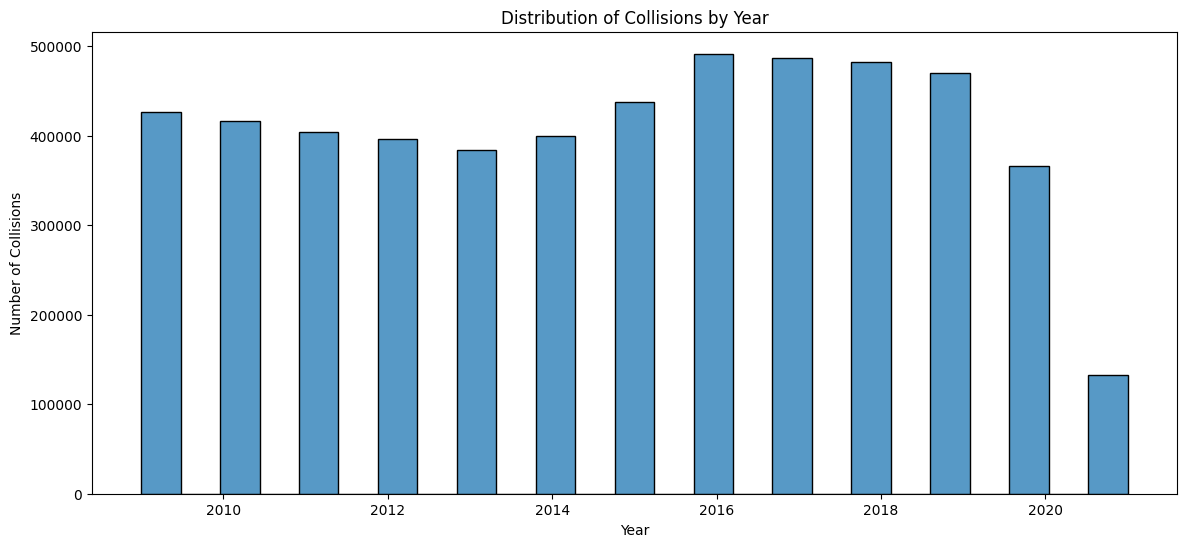

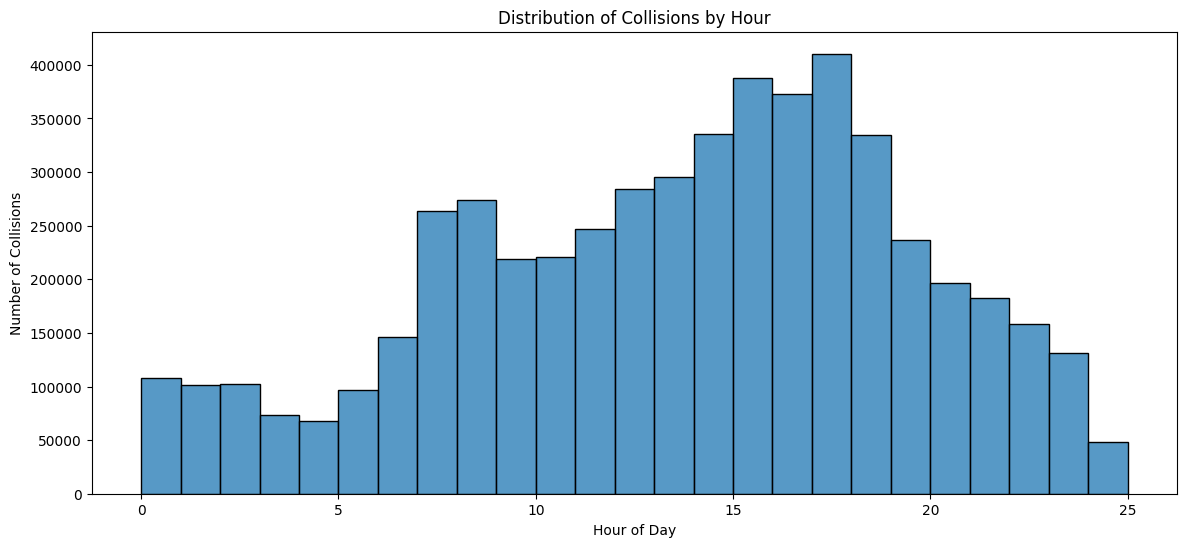

In [ ]:
plt.figure(figsize=(14, 6))
sns.histplot(collision_df['YEAR'], bins=25)
plt.title('Distribution of Collisions by Year')
plt.xlabel('Year')
plt.ylabel('Number of Collisions')
plt.show()

plt.figure(figsize=(14, 6))
sns.histplot(collision_df['HOUR'], bins=25, kde=False)
plt.title('Distribution of Collisions by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Collisions')
plt.show()

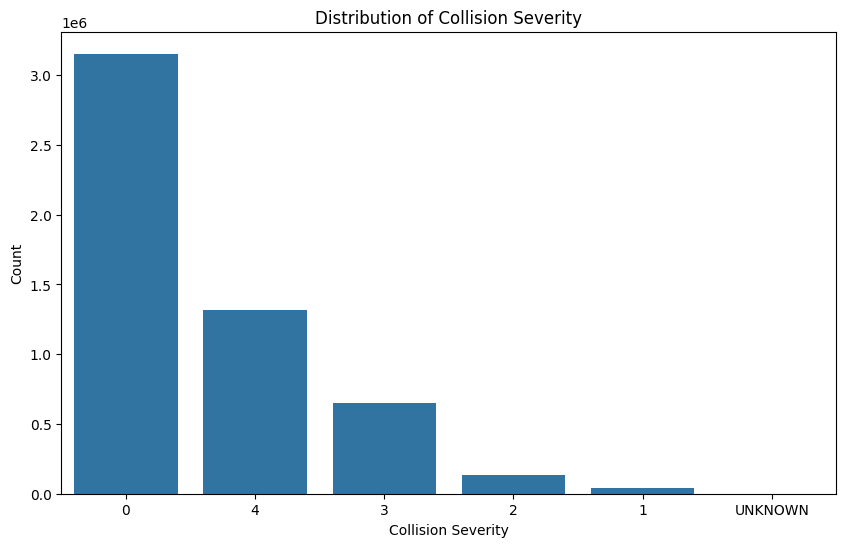

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=collision_df, x='COLLISION_SEVERITY', order=collision_df['COLLISION_SEVERITY'].value_counts().index)
plt.title('Distribution of Collision Severity')
plt.xlabel('Collision Severity')
plt.ylabel('Count')
plt.show()


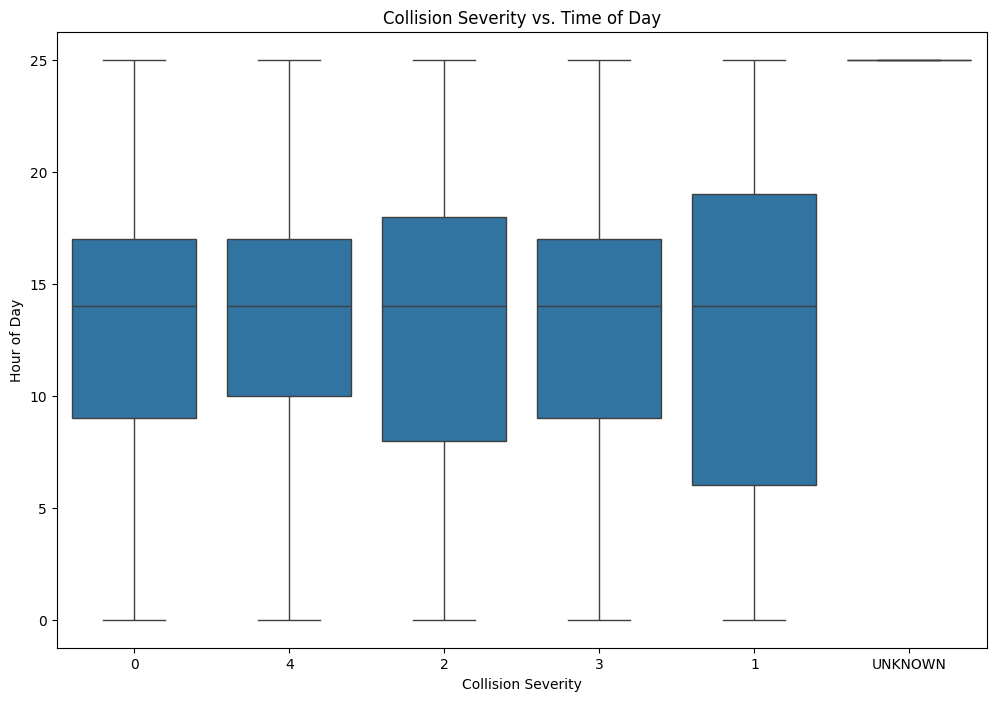

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='COLLISION_SEVERITY', y='HOUR', data=collision_df)
plt.title('Collision Severity vs. Time of Day')
plt.xlabel('Collision Severity')
plt.ylabel('Hour of Day')
plt.show()

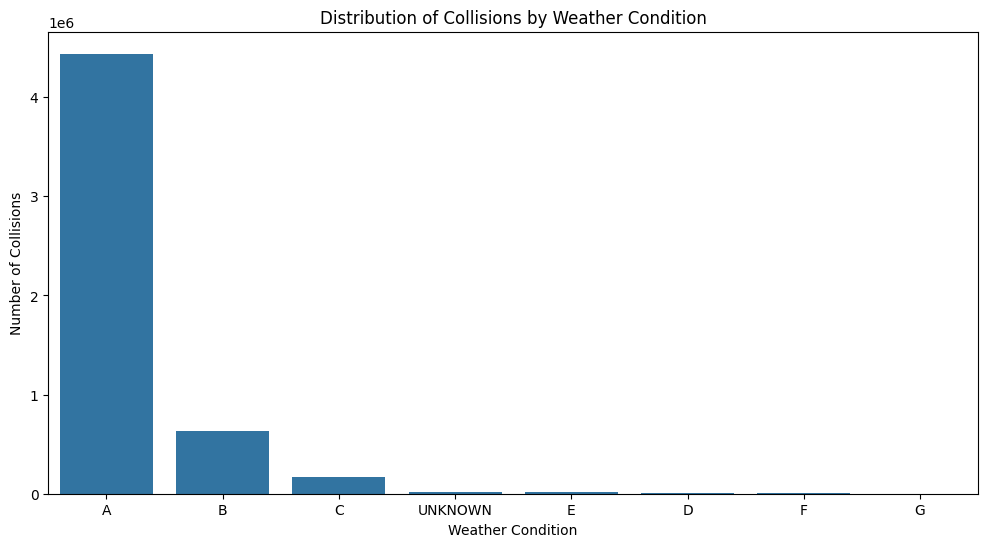

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=collision_df, x='WEATHER_1', order=collision_df['WEATHER_1'].value_counts().index)
plt.title('Distribution of Collisions by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Number of Collisions')
plt.show()


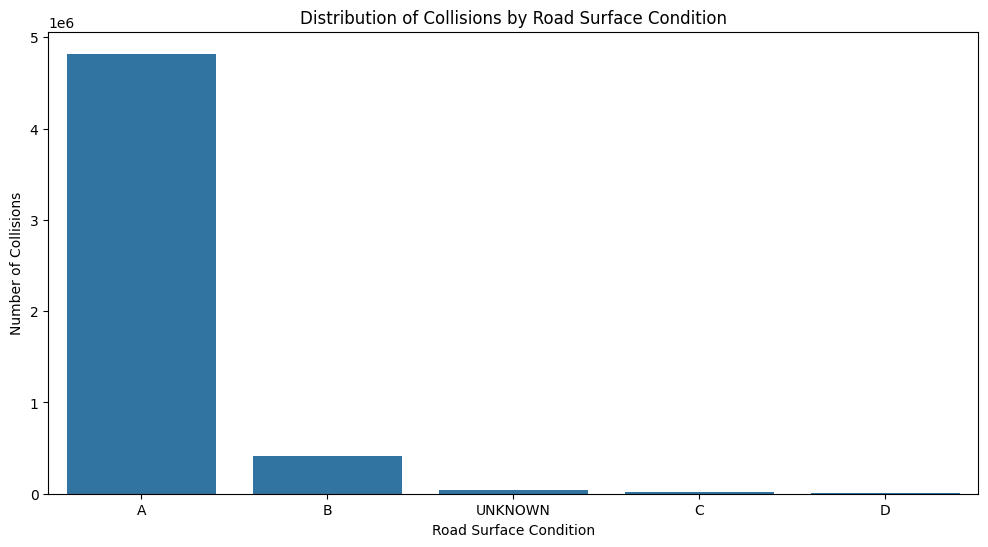

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=collision_df, x='ROAD_SURFACE', order=collision_df['ROAD_SURFACE'].value_counts().index)
plt.title('Distribution of Collisions by Road Surface Condition')
plt.xlabel('Road Surface Condition')
plt.ylabel('Number of Collisions')
plt.show()


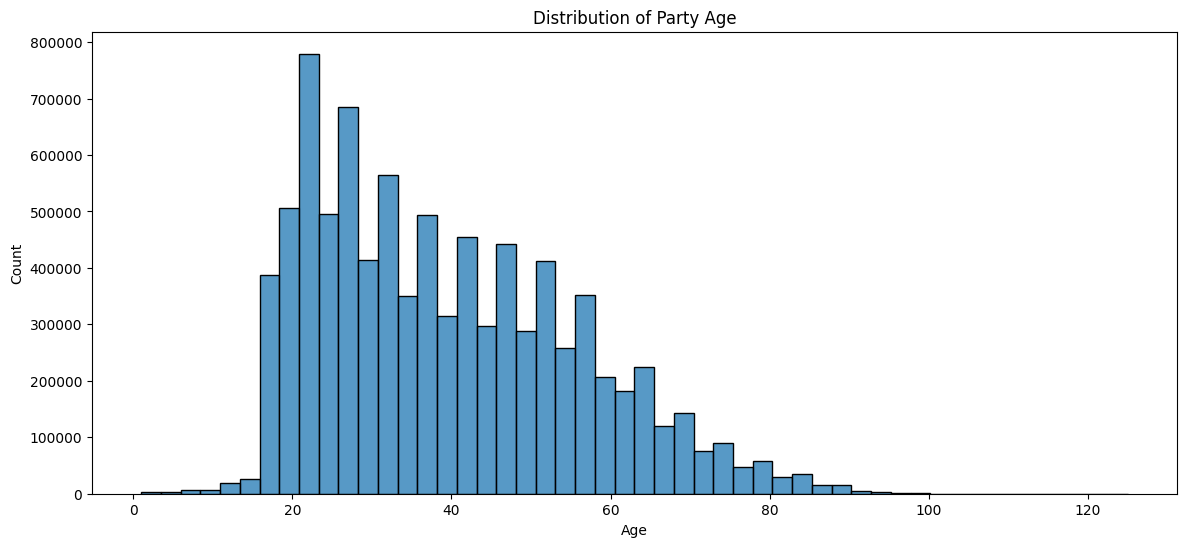

In [ ]:
plt.figure(figsize=(14, 6))
sns.histplot(party_df[party_df['PARTY_AGE'] != 'UNKNOWN']['PARTY_AGE'].astype(int), bins=50)
plt.title('Distribution of Party Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


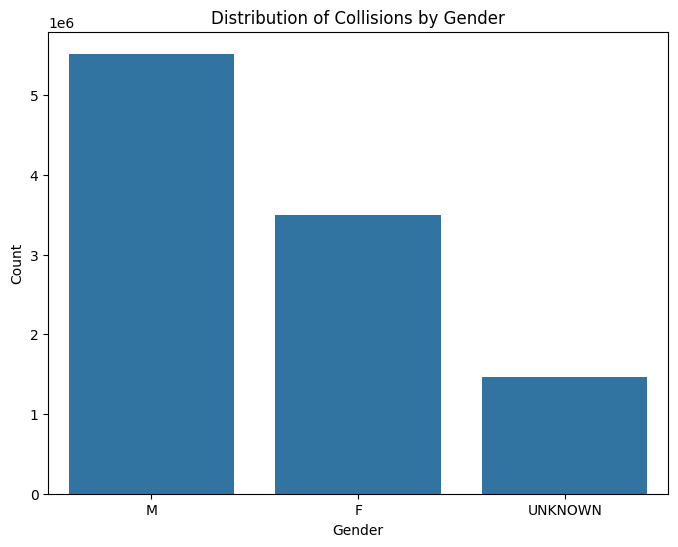

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data=party_df, x='PARTY_SEX', order=party_df['PARTY_SEX'].value_counts().index)
plt.title('Distribution of Collisions by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


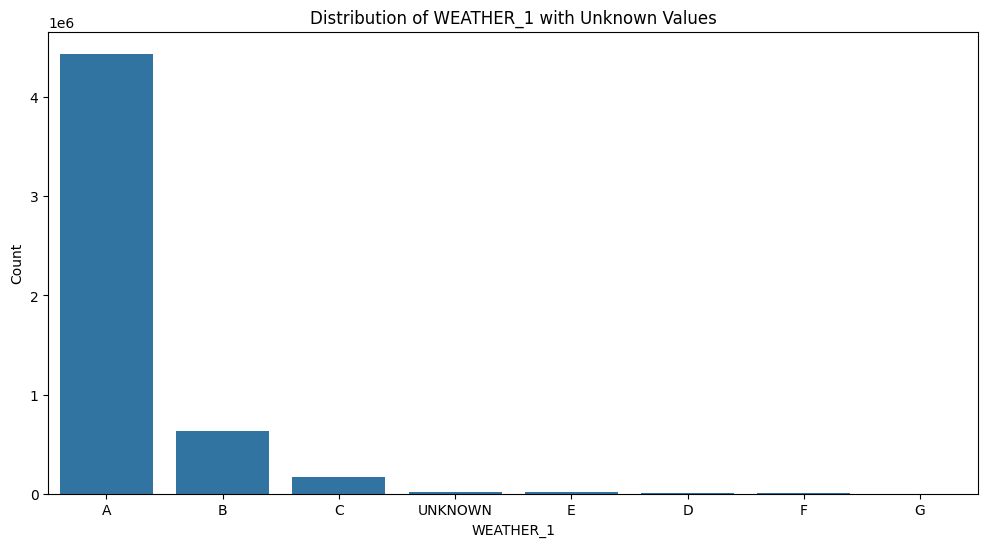

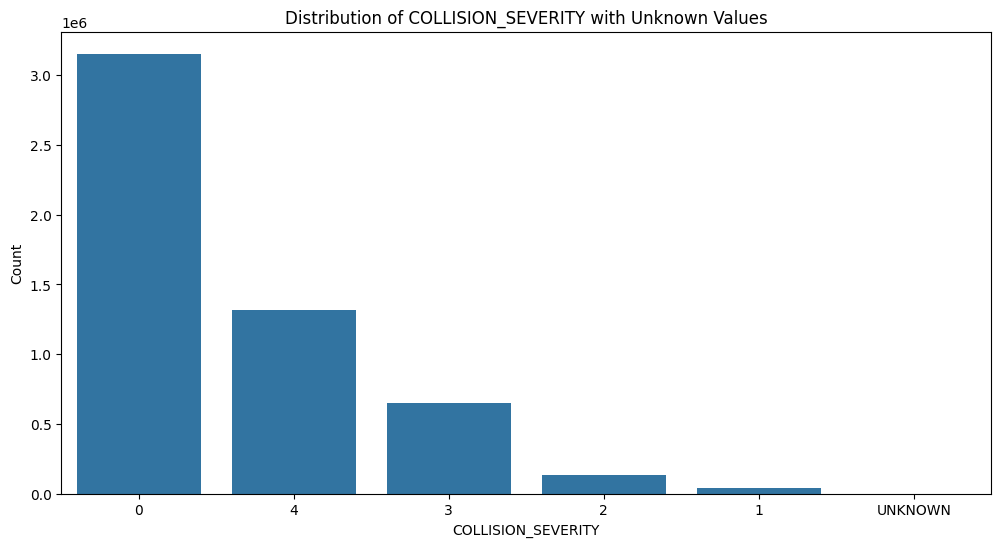

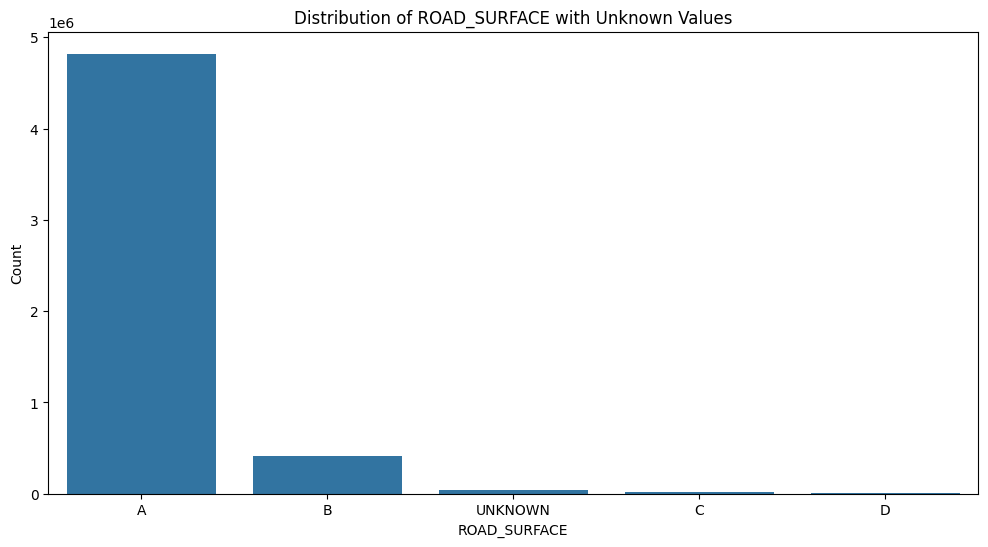

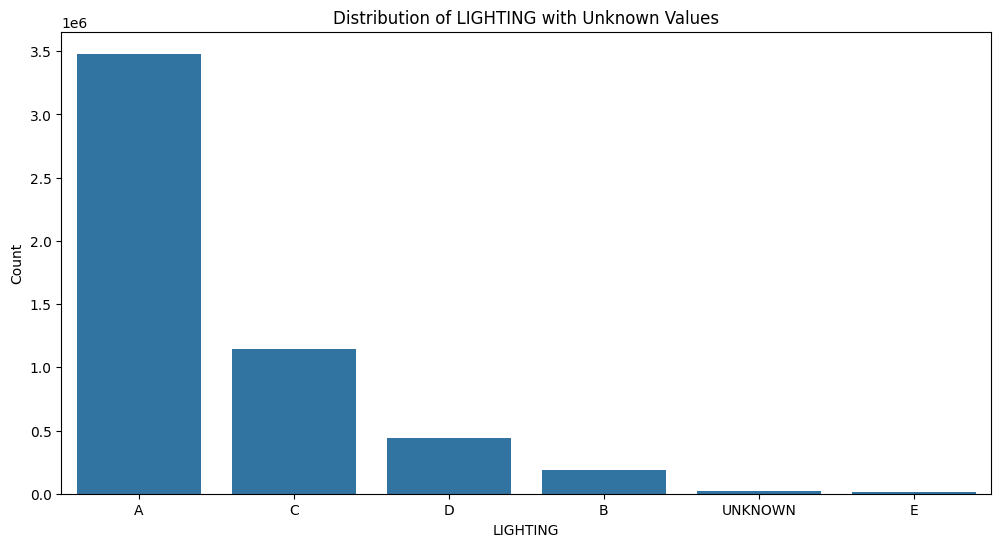

In [ ]:
unknown_columns = ['WEATHER_1', 'COLLISION_SEVERITY', 'ROAD_SURFACE', 'LIGHTING']
for col in unknown_columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=collision_df, x=col, order=collision_df[col].value_counts().index)
    plt.title(f'Distribution of {col} with Unknown Values')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()


                                HOUR  DAY_OF_WEEK  COLLISION_SEVERITY_1  \
HOUR                        1.000000    -0.000673             -0.003899   
DAY_OF_WEEK                -0.000673     1.000000              0.013968   
COLLISION_SEVERITY_1       -0.003899     0.013968              1.000000   
COLLISION_SEVERITY_2        0.001192     0.026095             -0.013731   
COLLISION_SEVERITY_3       -0.003773     0.021434             -0.031723   
COLLISION_SEVERITY_4        0.023106    -0.025324             -0.048725   
COLLISION_SEVERITY_UNKNOWN  0.000888     0.000240             -0.000037   
WEATHER_1_B                -0.062937    -0.014705              0.002510   
WEATHER_1_C                -0.011412     0.016997             -0.003956   
WEATHER_1_D                -0.001020     0.004109             -0.001109   
WEATHER_1_E                -0.049899     0.004345              0.006153   
WEATHER_1_F                 0.003773     0.001824              0.001598   
WEATHER_1_G              

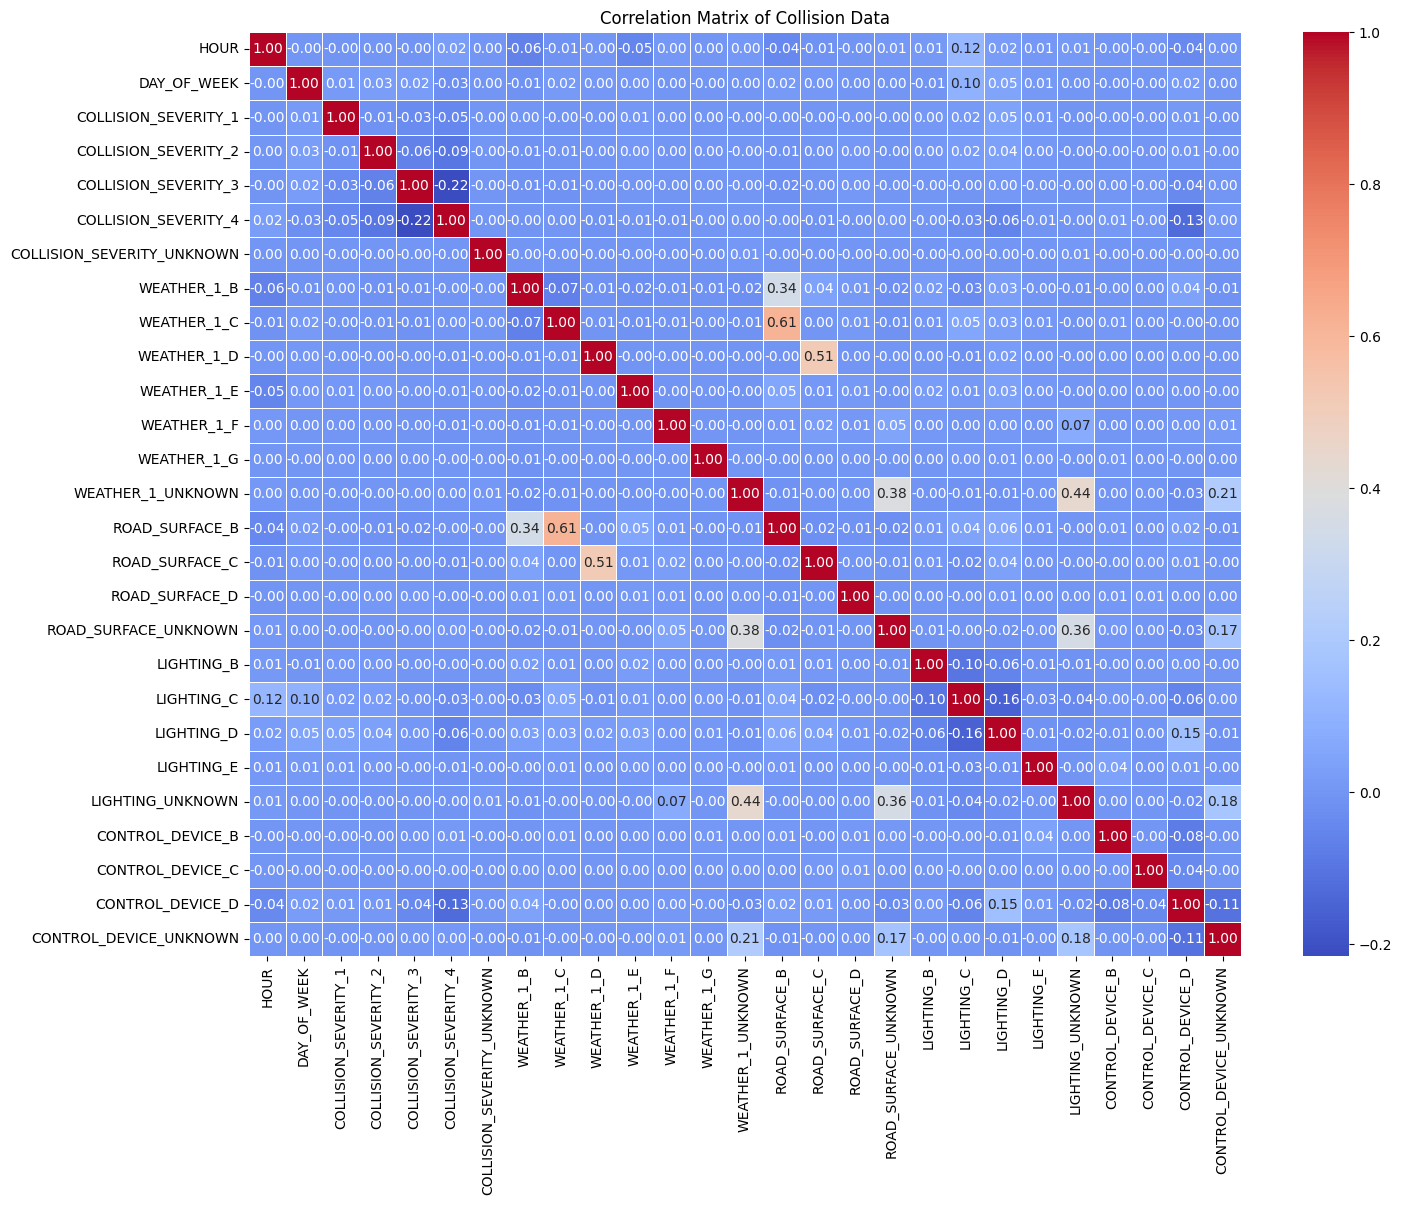

In [ ]:
encoded_df = pd.get_dummies(collision_df[[ 'COLLISION_SEVERITY', 'WEATHER_1', 'ROAD_SURFACE', 'LIGHTING', 'CONTROL_DEVICE']], drop_first=True)

corr_df = pd.concat([collision_df[['HOUR', 'DAY_OF_WEEK']], encoded_df], axis=1)

correlation_matrix = corr_df.corr()

print(correlation_matrix)

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Collision Data')
plt.show()


In [ ]:
# DST Start Dates
dst_start_dates = [
    '2009-03-08', '2010-03-14', '2011-03-13', '2012-03-11', '2013-03-10',
    '2014-03-09', '2015-03-08', '2016-03-13', '2017-03-12', '2018-03-11',
    '2019-03-10', '2020-03-08', '2021-03-14'
]

# DST End Dates
dst_end_dates = [
    '2009-11-01', '2010-11-07', '2011-11-06', '2012-11-04', '2013-11-03',
    '2014-11-02', '2015-11-01', '2016-11-06', '2017-11-05', '2018-11-04',
    '2019-11-03', '2020-11-01', '2021-11-07'
]

collision_df['DST_PERIOD'] = 'NORMAL'
collision_df.loc[collision_df['COLLISION_DATE'].isin(pd.to_datetime(dst_start_dates)), 'DST_PERIOD'] = 'POST_DST_START'
collision_df.loc[collision_df['COLLISION_DATE'].isin(pd.to_datetime(dst_end_dates)), 'DST_PERIOD'] = 'POST_DST_END'

In [ ]:
collision_df['DST_PERIOD'] = pd.Categorical(collision_df['DST_PERIOD'], categories=['NORMAL', 'POST_DST_START', 'POST_DST_END'])

In [ ]:
collision_df['DST_PERIOD'].value_counts()

,count
DST_PERIOD,
NORMAL,5268463
POST_DST_START,12474
POST_DST_END,12424


In [ ]:
collision_df.columns

Index(['CASE_ID', 'COLLISION_DATE', 'COLLISION_TIME', 'DAY_OF_WEEK',
       'WEATHER_1', 'COLLISION_SEVERITY', 'TYPE_OF_COLLISION', 'ROAD_SURFACE',
       'LIGHTING', 'CONTROL_DEVICE', 'PEDESTRIAN_ACCIDENT', 'BICYCLE_ACCIDENT',
       'MOTORCYCLE_ACCIDENT', 'TRUCK_ACCIDENT', 'YEAR', 'MONTH', 'DAY', 'HOUR',
       'DST_PERIOD'],
      dtype='object')

In [ ]:
normal_df = collision_df[collision_df['DST_PERIOD'] == 'NORMAL']
post_dst_start_df = collision_df[collision_df['DST_PERIOD'] == 'POST_DST_START']
post_dst_end_df = collision_df[collision_df['DST_PERIOD'] == 'POST_DST_END']

normal_sampled_df = normal_df.sample(n=15000, random_state=42)

reduced_df = pd.concat([normal_sampled_df, post_dst_start_df, post_dst_end_df])

reduced_df['DST_PERIOD'].value_counts()
reduced_df.columns

Index(['CASE_ID', 'COLLISION_DATE', 'COLLISION_TIME', 'DAY_OF_WEEK',
       'WEATHER_1', 'COLLISION_SEVERITY', 'TYPE_OF_COLLISION', 'ROAD_SURFACE',
       'LIGHTING', 'CONTROL_DEVICE', 'PEDESTRIAN_ACCIDENT', 'BICYCLE_ACCIDENT',
       'MOTORCYCLE_ACCIDENT', 'TRUCK_ACCIDENT', 'YEAR', 'MONTH', 'DAY', 'HOUR',
       'DST_PERIOD'],
      dtype='object')

# Model Creation and Results

In [ ]:
X = reduced_df.drop(columns=['DST_PERIOD', 'CASE_ID', 'COLLISION_DATE'])
y = reduced_df['DST_PERIOD']

X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), ['COLLISION_SEVERITY', 'WEATHER_1', 'ROAD_SURFACE', 'LIGHTING', 'CONTROL_DEVICE']),
    (StandardScaler(), ['HOUR', 'DAY_OF_WEEK']),
    remainder='drop'
)

Best parameters for Logistic Regression:
{'logisticregression__C': 0.01, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}
Best cross-validation accuracy: 0.6853
Best Logistic Regression Model:
Accuracy: 0.6822
Precision: 0.7072
Recall: 0.6822
F1-Score: 0.6826
                precision    recall  f1-score   support

        NORMAL       1.00      0.89      0.94      3019
  POST_DST_END       0.55      0.38      0.45      2491
POST_DST_START       0.50      0.73      0.59      2470

      accuracy                           0.68      7980
     macro avg       0.69      0.67      0.66      7980
  weighted avg       0.71      0.68      0.68      7980



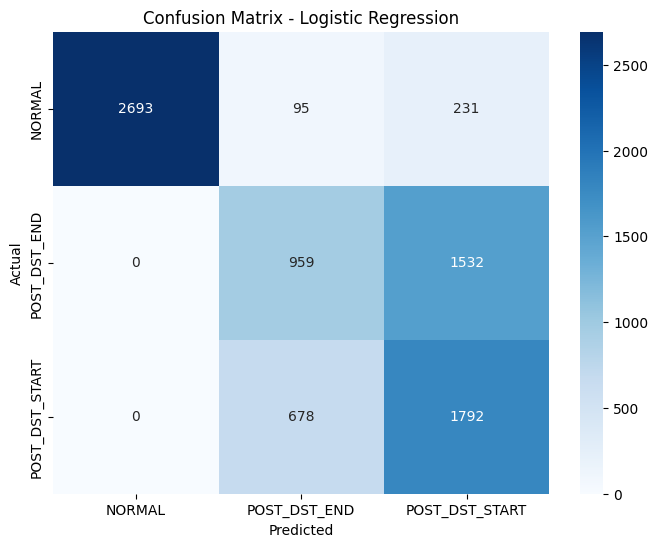

In [ ]:
logreg_pipeline = make_pipeline(
    preprocessor,
    LogisticRegression(multi_class='ovr', max_iter=1000, random_state=42)
)

param_grid_logreg = {
    'logisticregression__C': [0.001, 0.01, 0.1],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['liblinear', 'saga']
}

grid_logreg = GridSearchCV(logreg_pipeline, param_grid_logreg, cv=5, scoring='accuracy', n_jobs=-1)
grid_logreg.fit(X_train_reduced, y_train_reduced)

print("Best parameters for Logistic Regression:")
print(grid_logreg.best_params_)
print(f"Best cross-validation accuracy: {grid_logreg.best_score_:.4f}")

y_pred_best_logreg = grid_logreg.best_estimator_.predict(X_test_reduced)

print("Best Logistic Regression Model:")
print(f"Accuracy: {accuracy_score(y_test_reduced, y_pred_best_logreg):.4f}")
print(f"Precision: {precision_score(y_test_reduced, y_pred_best_logreg, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test_reduced, y_pred_best_logreg, average='weighted'):.4f}")
print(f"F1-Score: {f1_score(y_test_reduced, y_pred_best_logreg, average='weighted'):.4f}")
print(classification_report(y_test_reduced, y_pred_best_logreg))

conf_matrix_logreg = confusion_matrix(y_test_reduced, y_pred_best_logreg)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_logreg, annot=True, fmt="d", cmap='Blues',
            xticklabels=grid_logreg.best_estimator_.named_steps['logisticregression'].classes_,
            yticklabels=grid_logreg.best_estimator_.named_steps['logisticregression'].classes_)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Best parameters for Random Forest:
{'randomforestclassifier__max_depth': 15, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 200}
Best cross-validation accuracy: 0.7147
Best Random Forest Model:
Accuracy: 0.7143
Precision: 0.7331
Recall: 0.7143
F1-Score: 0.7207
                precision    recall  f1-score   support

        NORMAL       1.00      0.89      0.94      3019
  POST_DST_END       0.59      0.55      0.57      2491
POST_DST_START       0.55      0.67      0.60      2470

      accuracy                           0.71      7980
     macro avg       0.71      0.70      0.70      7980
  weighted avg       0.73      0.71      0.72      7980



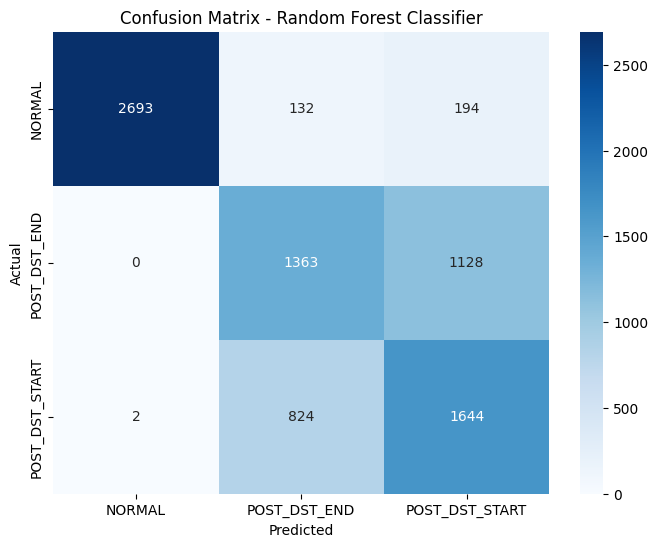

In [ ]:
rf_pipeline = make_pipeline(
    preprocessor,
    RandomForestClassifier(random_state=42)
)

param_grid_rf = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_depth': [10, 15],
    'randomforestclassifier__min_samples_split': [2, 5],
}

grid_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train_reduced, y_train_reduced)

print("Best parameters for Random Forest:")
print(grid_rf.best_params_)
print(f"Best cross-validation accuracy: {grid_rf.best_score_:.4f}")

y_pred_best_rf = grid_rf.best_estimator_.predict(X_test_reduced)

print("Best Random Forest Model:")
print(f"Accuracy: {accuracy_score(y_test_reduced, y_pred_best_rf):.4f}")
print(f"Precision: {precision_score(y_test_reduced, y_pred_best_rf, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test_reduced, y_pred_best_rf, average='weighted'):.4f}")
print(f"F1-Score: {f1_score(y_test_reduced, y_pred_best_rf, average='weighted'):.4f}")
print(classification_report(y_test_reduced, y_pred_best_rf))

conf_matrix_rf = confusion_matrix(y_test_reduced, y_pred_best_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap='Blues',
            xticklabels=grid_rf.best_estimator_.named_steps['randomforestclassifier'].classes_,
            yticklabels=grid_rf.best_estimator_.named_steps['randomforestclassifier'].classes_)
plt.title("Confusion Matrix - Random Forest Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Best parameters for SVM:
{'svc__C': 1, 'svc__kernel': 'rbf'}
Best cross-validation accuracy: 0.6984
Best SVM Model:
Accuracy: 0.6931
Precision: 0.7127
Recall: 0.6931
F1-Score: 0.6995
                precision    recall  f1-score   support

        NORMAL       1.00      0.89      0.94      3019
  POST_DST_END       0.53      0.65      0.58      2491
POST_DST_START       0.54      0.50      0.52      2470

      accuracy                           0.69      7980
     macro avg       0.69      0.68      0.68      7980
  weighted avg       0.71      0.69      0.70      7980



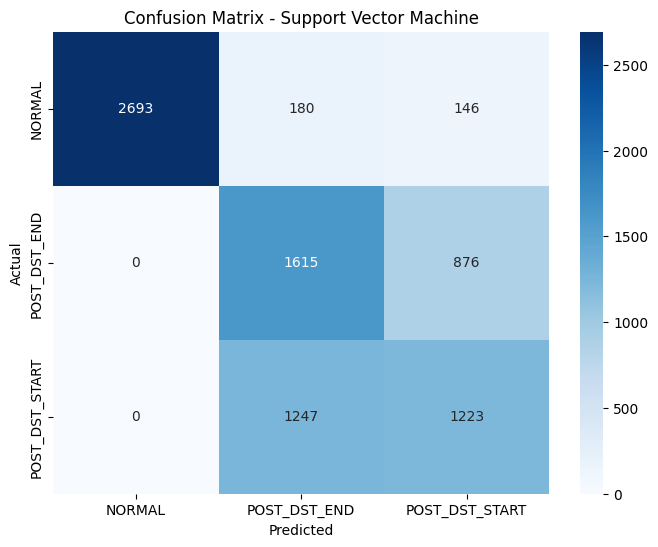

In [ ]:
svm_pipeline = make_pipeline(
    preprocessor,
    SVC(random_state=42)
)

param_grid_svm = {
    'svc__C': [0.1, 1],
    'svc__kernel': ['linear', 'rbf']
}

grid_svm = GridSearchCV(svm_pipeline, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train_reduced, y_train_reduced)

print("Best parameters for SVM:")
print(grid_svm.best_params_)
print(f"Best cross-validation accuracy: {grid_svm.best_score_:.4f}")

y_pred_best_svm = grid_svm.best_estimator_.predict(X_test_reduced)

print("Best SVM Model:")
print(f"Accuracy: {accuracy_score(y_test_reduced, y_pred_best_svm):.4f}")
print(f"Precision: {precision_score(y_test_reduced, y_pred_best_svm, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test_reduced, y_pred_best_svm, average='weighted'):.4f}")
print(f"F1-Score: {f1_score(y_test_reduced, y_pred_best_svm, average='weighted'):.4f}")
print(classification_report(y_test_reduced, y_pred_best_svm))

conf_matrix_svm = confusion_matrix(y_test_reduced, y_pred_best_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap='Blues',
            xticklabels=grid_svm.best_estimator_.named_steps['svc'].classes_,
            yticklabels=grid_svm.best_estimator_.named_steps['svc'].classes_)
plt.title("Confusion Matrix - Support Vector Machine")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()